# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "guillaume"
ln1 = "leveque"
fn2 = "oumayma"
ln2 = "bounou"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_leveque_guillaume_and_bounou_oumayma.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

ANSWER HERE

The problem $(\mathcal{P})$ can be rewritten as : 

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \mathcal{f_1}(w)  + \mathcal{f_2}(\rho) + \frac{1}{\nu n} \sum_{i=1}^n \mathcal{f_3}(\xi_i) \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

1. The square function $\mathcal{f_1}$, and affine functions $\mathcal{f_2}$ and $\mathcal{f_3}$ are convex, the sum of convex functions is convex, so the objective function is convex.
2. The constrains are convex 

Thus the problem $(\mathcal{P})$ is convex

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

Let's write the Lagrangian function of this problem :

$$
\mathcal{L}(w,\rho, \xi, \mu, \lambda) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n \mu_i (\rho - \xi_i - \langle w, x_i \rangle) - \sum_{i=1}^n \lambda_i \xi_i
$$

$$
\mu \in \mathbb{R}_+^n \\
\lambda \in \mathbb{R}_+^n
$$

The goal is:
$$
\\
\max_{\mu, \lambda}\min_{w, \rho, \xi} \mathcal{L}(w, \xi, \mu, \lambda)
$$
Let's first focus on $$ \min_{w,\xi} \mathcal{L}(w, \rho, \xi, \mu, \lambda)$$

Computing the gradient on w, we have:

$$
\nabla \, \frac{1}{2}\Vert w \Vert^2 - \sum_{i=1}^n \mu_i \langle w, x_i \rangle = 0 \leftrightarrow w^* =  \sum_{i=1}^n \mu_i x_i \\
$$
Computing the gradient on $\rho$, we have:
$$
\nabla \, \rho (\sum_{i=1}^n \mu_i - 1) = 0 \leftrightarrow \sum_{i=1}^n \mu_i^* = 1 \\
$$
Computing the gradient on $\xi$, we have:
$$
\nabla \, \sum_{i=1}^n \xi_i \, (\frac{1}{\nu n} -\mu_i -\lambda_i) \leftrightarrow \, \forall i \, \mu_i^* + \lambda_i^* = \frac{1}{\nu n} 
$$
Now the problem becomes:
$$
\max_{\mu, \lambda} \mathcal{L}(w^*,\rho^*, \xi^*, \mu, \lambda)  = \max_{\mu} \,- \frac{1}{2} \sum_{i,j=1}^{n} \mu_i x_i^{t}x_j\mu_i
$$

which is equivalent to

$$
 \begin{array}{lll}
 \min_{\mu} \, \frac{1}{2} \sum_{i,j=1}^{n} \mu_i x_i^{t}x_j\mu_i
 \end{array}
$$

Using the KKT condtions : 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} \frac{1}{2}\mu^{\top}GG^{t}\mu
 \\\forall i \, \mu_i^* + \lambda_i^* = \frac{1}{\nu n} 
 \\  \sum_{i=1}^n \mu_i^* = 1 
 \\
\mu \in \mathbb{R}_+^n \\
\lambda \in \mathbb{R}_+^n \\
 \end{array}
 \right .
$$

Thus

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

ANSWER HERE

<div class="a">
     <ul>
     <li>The form of the prediction function is : 
        $$
        y = \mathrm{sign}(\langle w, x_j \rangle - \rho) = \mathrm{sign}(w^\top x_j - \rho) \enspace
        \\
        $$
        
        We know that the vector $w$ = $\sum_{i=1}^{n} \mu_i x_i$. Then,
        $$
        y = \mathrm{sign}((\sum_{i=1}^{n} \mu_i x_i)^\top x_j - \rho) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x_j - \rho)
        $$
    </li>
    </ul>
</div>

## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

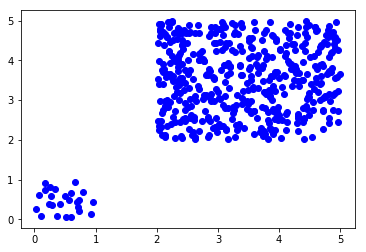

In [3]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [4]:
import cvxopt


def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
 
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [5]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [6]:
def ocsvm_solver(K, nu=0.1):
    P = K
    n = P.shape[0]
    q = np.zeros(n)
    A = np.ones([1, n])
    b = 1.0
    C = 1 / (nu * n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support, mu

K = kernel(X, X)

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support, mu = ocsvm_solver(K)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 50


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

In [7]:
w = np.dot(mu, X)

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

### ANSWER

Let us pick an index i such as $$ 0 < \mu_i < \frac{1}{\nu n} $$
$$ $$

To satisfy complementary slackness, one must have
$$
 \left\{
 \begin{array}{lll}
 \lambda_i\xi_i = 0
 \\
 \mu_i (\rho - \xi_i - <w,x_i>) = 0
 \end{array}
 \right .
$$

which is equivalent to 

$$
 \left\{
 \begin{array}{lll}
 (\frac{1}{\nu n} - \mu_i)\xi_i = 0
 \\
 \mu_i (\rho - \xi_i - <w,x_i>) = 0
 \end{array}
 \right .
$$

Since we assumed $\mu_i \neq \frac{1}{\nu n}$ we thus have

$$
 \left\{
 \begin{array}{lll}
 \xi_i = 0
 \\
 \mu_i (\rho - <w,x_i>) = 0
 \end{array}
 \right .
$$

Since we assumed $\mu_i \neq 0$ we thus have

$$\rho = <w, x_i>$$
$$ \rho = w^\top x_i$$


In [8]:
def compute_rho(K, mu_support, idx_support):
    K_support = K[idx_support][:, idx_support]
    j = np.min(idx_support)
    #j = np.random.choice([idx for idx in idx_support if idx < idx_support.shape[0]])
    #rho = np.dot(mu_support, K_support[j])
    rho = np.dot(mu_support, K_support)
    print(rho)
    #rho = np.dot(mu, K[j])
    rho = max(rho)
    return rho

rho = compute_rho(K, mu_support, idx_support)

[ 1.24182958  6.46528183  0.24984134  5.90345564  1.3032608   1.91998015
  6.03505158  6.34159119  1.184665    0.88959742  1.54427033  0.40288241
  1.49642151  6.16953916  6.7570988   1.46336704  1.73928089  6.04688898
  6.21939856  0.88550382  0.94179984  1.45029883  5.79295647  6.00774237
  5.85532946  6.45991311  5.9888194   1.51812276  1.39744066  6.18072244
  6.52354951  0.87199636  1.1022279   2.05373728  1.68229184  6.54734707
  6.65184874  2.19924451  6.24547302  5.77740103  6.39526069  6.59169413
  0.62251234  6.67003904  6.59378904  1.50233905  6.6885758   6.12064178
  1.43294291  0.77865577]


In [9]:
rho

6.7570987967128637

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [10]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support, mu = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print("support vectors indices check")
print(ocsvm.support_)
print(idx_support)

# Check rho
print("")
print("rho check")
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print("")
print("dual variables check")
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[ 0.60530647  0.51202496  2.16400352  0.42015071  0.49497336  0.327807
  0.30335601  0.03323448]
support vectors indices check
[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]

rho check
2.16400352023
2.16400355501

dual variables check
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

[ 0.36056398  0.37788447  0.36033269  0.2384426   0.59792174  0.80681927
  0.0996762   0.35904163  0.58311576  0.12492406  0.09227141  0.65236909
  0.49665444  0.45809042  0.32724612]


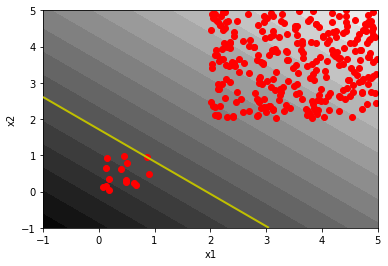

In [11]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support, mu = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

ANSWER HERE

- To be able to apply proximal gradient descent, or coordinate descent, we need to have an objective function of the type
$$ f(w) = L(w) + \lambda R(w)$$ 
where L is smooth and convex, and R convex and prox-friendly, which is not the case here. 

- To apply stochastic gradient descent and L-BFGS, the objective function needs to be twice differentiable, which is not the case also. 

We thus can not apply any of the suggested algorithms to solve the dual problem.

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

$$ f(x) = sgn(\sum_{i=1}^n \mu_{i}x_{i}^{t}x - \rho)$$
$$ f(x) = sgn (\begin{pmatrix}\mu_{1}\\...\\\mu_{n}\end{pmatrix} \begin{pmatrix}x_{1}^{t}x\\...\\x_{n}^{t}x\end{pmatrix} - \rho) $$
$$ f(x) = sgn (\begin{pmatrix}\mu_{1}\\...\\\mu_{n}\end{pmatrix} \begin{pmatrix}K(x_{1},x)\\...\\K(x_{n},x)\end{pmatrix} - \rho)$$

We will use another dataset to evaluate this:

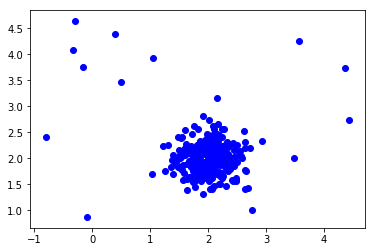

In [12]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [13]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(- gamma * np.linalg.norm((X1[i] - X2[j]), 2))
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

[ 0.61154744  0.41157387  0.6041409   0.43078934  0.4560655   0.61153947
  0.61011855  0.61154107  0.59275373  0.3374161   0.61154174  0.43807534
  0.61154148  0.61154104  0.61154191  0.59210482  0.38807661  0.57416389
  0.60684869]


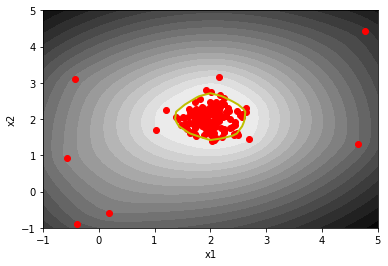

In [14]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support, mu = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

### ANSWER HERE

Let's write the Lagrangian of the problem:
$$
\mathcal{L}(w, \xi, \mu, \lambda) = \frac{1}{2} \Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n \mu_i(1 - \xi_i - <w, x_i>) - \sum_{i=1}^n \lambda_i \xi_i
\\
$$
The goal is:
$$
\\
\max_{\mu, \lambda}\min_{w,\xi} \mathcal{L}(w, \xi, \mu, \lambda)
$$
Let's first focus on $$ \min_{w,\xi} \mathcal{L}(w, \xi, \mu, \lambda)$$

Computing the gradient according to w:
$$ 
w - \sum_{i=1}^n \mu_i x_i = 0
\\
w^* = \sum_{i=1}^n \mu_i x_i
$$
Computing the gradient according to $\xi$:
$$
\frac{C}{n} - \mu_i - \lambda_i = 0
\\
\mu_i + \lambda_i = \frac{C}{n}
\\
\\
\mathcal{L}(w^*,\, \xi^*,\, \mu,\, \lambda) = \frac{-1}{2} \sum_{i,j=1}^n \mu_i x_i^\top x_j \mu_j + \sum_{i=1}^n\mu_i
\\
\mathcal{L}(w^*,\, \xi^*,\, \mu,\, \lambda) = \frac{-1}{2} \mu^\top GG^\top \mu + \mu^\top 1_n
$$
Our objective now is:
$$
\max_{\mu, \lambda} \frac{-1}{2} \mu^\top GG^\top \mu + \mu^\top 1_n
$$
Or equivalently 
$$ \min_{mu} \frac{1}{2} \mu^\top GG^\top \mu - \mu^\top 1_n$$

The condition $\forall i\,\,\, \lambda_i ≥0$ gives us
$$
\forall i \in [1,\, n]\,\,\,\,\, 0≤\mu_i≤\frac{C}{\nu n}
\\
or\,\,\, 0≤\mu≤\frac{C}{\nu n}
$$

We thus obtain
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



#### We have
#### $$(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .$$
#### Where $$ f(\mu) = \frac{1}{2}\mu^{\top}GG^{\top}\mu -\mu^{\top} 1_n $$ 

#### and
$$ g(\mu )
        =
            \left\{
            \begin{array}{lll}
            0\,\, if\,\, \frac{C}{n} - \mu ≥0 \,\,\, and \,\,\, \mu ≥0
            \\
            \ \infty \,\, otherwise
            \end{array}
            \right .
        $$

#### with $$ \forall i \in [1, n]\, \,\,\, g_i(\mu_i)
        =
            \left\{
            \begin{array}{lll}
            0\,\, if\,\, \frac{C}{n} - \mu_i ≥0\,\,\, and\,\,\, \mu_i ≥0
            \\
            \ \infty \,\, otherwise
            \end{array}
            \right .
        $$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

#### Solver using QP

In [15]:
def norho_ocsvm_solver(K, nu=0.1):
    P = K_rbf
    n = P.shape[0]
    q = - np.ones([n, 1]) 
    #A = np.ones(n).reshape(1, n)
    A = np.zeros([1, n])
    b = 0.0
    C = 1 / (nu * n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support, mu

In [16]:
X = make_blob_dataset(150)
K = kernel(X, X)

K_rbf = rbf_kernel(X, X)
norho_ocsvm_solver(K_rbf)

ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [167]:
n_iter=1000

In [168]:
import time

def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = np.linalg.norm(xk - x_min)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 10) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [204]:
from scipy.linalg import svd


class OneClassSVMDual(object):

    def __init__(self, X, C):
        self.X = X
        self.C = C
        self.n = X.shape[0]
        self.K = rbf_kernel(X, X)
        

    def grad(self, mu):
        return  np.dot(self.K , mu) - np.ones(self.n)

    def f(self, mu):
        return 1./2 * np.dot(mu.T, np.dot(self.K, mu)) - np.sum(mu)
    
    def g(self, mu):
        if np.any(self.C / self.n - mu < 0):
                  return np.inf
        elif np.any(mu < 0):
                return np.inf
        else:
            return 0
        
    def prox(self, mu):
        prox = []
        for mu_i in np.nditer(mu):
            if mu_i < 0:
                prox.append(0)
            elif mu_i > self.C / self.n:
                prox.append(self.C / self.n)
            else:
                prox.append(mu_i)
        
        return np.asarray(prox)
    
    
    def prox_i (self, mu):
        if mu < 0:
                return 0
        elif mu > self.C / self.n:
                return self.C / self.n
        else:
            return mu
    
    
    def obj(self, mu):
        return self.f(mu) + self.g(mu)

    def grad_i(self, i, x):
        k_i = self.K[i]
        return (k_i.dot(x) - 1)

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return np.linalg.norm(self.K, ord=2) 
    
    def lipschitz_constant_i(self, i):
        return self.K[:, i].T.dot(self.K[:, i])

#### Using scipy fmin_l_bfgs_b

In [283]:
from scipy.optimize import fmin_l_bfgs_b
x0 = np.ones(K_rbf.shape[0])

OC = OneClassSVMDual(X, 1000)
x_min, f_min, _ = fmin_l_bfgs_b(OC.f, x0, fprime=OC.grad)

bfgs_inspector = inspector(OC.f, x_min, verbose=False)
x_bfgs, _, _ = fmin_l_bfgs_b(OC.f, x0, OC.grad, maxiter=n_iter, callback=bfgs_inspector)

In [284]:
f_min

-1.2106889510291137

#### Using ISTA

In [285]:
from scipy.optimize import check_grad


# Check that the gradient and the loss numerically match
check_grad(OC.f, OC.grad, np.random.randn(K.shape[0]))

1.0700195213727247e-05

In [286]:
def ista(x_init, grad, prox, n_iter=1000, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    x_new = x_init.copy()
    for _ in range(n_iter):       
        x_new = prox(x - step * grad(x))
        
        x = x_new.copy()
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [287]:
x0 = np.ones(K.shape[0])
step = 1. / OC.lipschitz_constant()

In [314]:
ista_inspector = inspector(OC.obj, x_min, verbose=True)
x = ista(x_init=x0, grad=OC.grad, prox=OC.prox, n_iter=1000, step=step, callback=ista_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.46e+00 | 6.26e-01 | 1.0591e-03
     100 | 1.07e-02 | 2.23e-01 | 5.7952e-02
     200 | 3.62e-03 | 1.77e-01 | 1.0530e-01
     300 | 2.36e-03 | 1.53e-01 | 1.5518e-01
     400 | 1.79e-03 | 1.36e-01 | 2.4106e-01
     500 | 1.44e-03 | 1.23e-01 | 3.1001e-01
     600 | 1.20e-03 | 1.13e-01 | 3.6925e-01
     700 | 1.04e-03 | 1.05e-01 | 4.3691e-01
     800 | 9.18e-04 | 9.89e-02 | 4.8468e-01
     900 | 8.33e-04 | 9.44e-02 | 5.4060e-01


#### Using FISTA

In [289]:
def fista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        x_new = prox(y - step * grad(y))
        
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2.
        
        y = x_new + (t - 1) / t_new * (x_new - x)
        
        x = x_new
        t = t_new

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [315]:
x_0 = np.ones(K.shape[0])
fista_inspector = inspector(OC.obj, x_min, verbose=True)
x_fista = fista(x_init=x0, grad=OC.grad, prox=OC.prox, n_iter=1000, step=step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 2.46e+00 | 6.26e-01 | 1.1320e-03
     100 | 6.48e-04 | 7.77e-02 | 6.2106e-02
     200 | 6.07e-04 | 7.72e-02 | 1.1622e-01
     300 | 6.02e-04 | 7.62e-02 | 1.6627e-01
     400 | 6.00e-04 | 7.62e-02 | 2.4645e-01
     500 | 5.99e-04 | 7.61e-02 | 3.0838e-01
     600 | 5.99e-04 | 7.60e-02 | 3.5767e-01
     700 | 5.99e-04 | 7.62e-02 | 4.1551e-01
     800 | 5.99e-04 | 7.62e-02 | 4.6420e-01
     900 | 5.99e-04 | 7.62e-02 | 5.2117e-01


#### Using coordinate descent

In [340]:
def cd(x_init, iis, grad_i, prox_i, K, n_iter, callback=None):
    
    x = x_init.copy()
    x_new = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        Li = K[:, i].T.dot(K[:, i])
        step_i = 1. / Li
        x_new[i] = prox_i(x[i] - step_i * grad_i(i, x))
        x = x_new
        
        
        if callback is not None :
            return callback(x)
    return x

In [341]:
iis = np.random.randint(0, X.shape[0], X.shape[0] * n_iter)  

In [342]:
cd_inspector = inspector(OC.obj, x_min, verbose=True)
x_cd = cd(x_init=x0, iis=iis, grad_i=OC.grad_i, prox_i=OC.prox_i, K=OC.K, n_iter=1000, callback=cd_inspector)

   it    |   obj    |   err    |   time  
       0 | 8.85e+03 | 1.20e+01 | 1.7431e-03


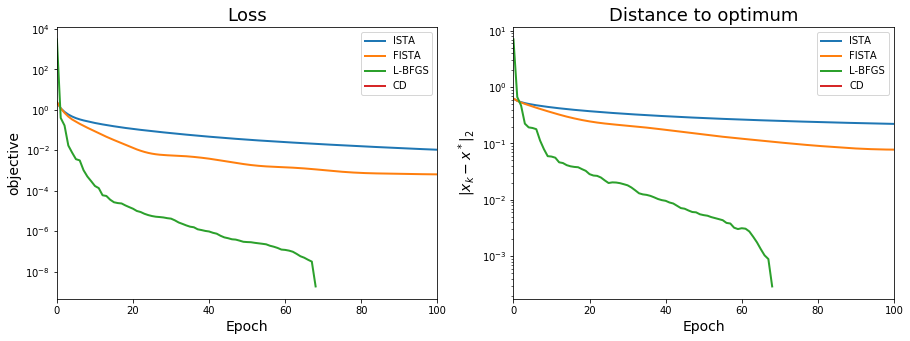

In [310]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, bfgs_inspector, cd_inspector]

solvers = ["ISTA", "FISTA", "L-BFGS", "CD"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)
    plt.xlim(0, 100)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.xlim(0, 100)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);